## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter

In [2]:
data_solvency = pd.read_csv('/datasets/data.csv')
data_solvency.info()
data_solvency.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


+ Наблюдаются следующие проблемы с данными:
    + В столбце __'days_emloyed'__ присутствуют отрицательные значения и значения, превышающие время жизни человека (отмечается у пенсионеров и безработных). Значения вещественные, хотя по смыслу должны быть целочисленными. Также есть отсутствующие значения;
    + В столбце __'total_income'__ у значений слишком много значащих цифр после запятой, вероятно вызвано особенностями расчёта величин. Также есть отсутствующие значения;
    + В столбце __'education'__ данные об образовании записаны в разном регистре;
    + В столбце __'purpose'__ одинаковые по смыслу цели записаны разными фразами, нужно будет проводить лемматизацию с последующей категоризацией.
    + В столбце __'dob_years'__ присутствуют нулевые значения. По всей видимости они означают пропуски. (Если бы нам в дальнейшем понадобился этот столбец, то пропуски можно было бы заполнить средним возрастом по всей выборке)


+ В дальнейшем столбец __'days_emloyed'__ рассматриваться не будет, поскольку для решения поставленных задач не требуется.

### Шаг 2. Предобработка данных

### Обработка пропусков

Для нашего исследования представляют интерес пропуски только в столбце __'total_income'__. Взглянем на них поближе.

In [3]:
data_solvency[data_solvency['total_income'].isna() == True]['education_id'].value_counts()

1    1540
0     544
2      69
3      21
Name: education_id, dtype: int64

In [4]:
data_solvency[data_solvency['total_income'].isna() == True]['family_status_id'].value_counts()

0    1237
1     442
4     288
3     112
2      95
Name: family_status_id, dtype: int64

In [5]:
data_solvency[data_solvency['total_income'].isna() == True]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

По приведённым табличкам видно, что пропуски имеются практически во всех категориях по образованию, семейному статусу и типу занятости. Если и есть какие-то закономерности в появлении пропусков, то по нашим данным это невозможно установить. Таким образом можно считать, что характер пропусков полностью случайный.

In [6]:
data_solvency.groupby('income_type')['total_income'].agg(['median', 'mean', 'count'])

,median,mean,count
income_type,,,
безработный,131339.751676,131339.751676,2
в декрете,53829.130729,53829.130729,1
госслужащий,150447.935283,170898.309923,1312
компаньон,172357.950966,202417.461462,4577
пенсионер,118514.486412,137127.465690,3443
предприниматель,499163.144947,499163.144947,1
сотрудник,142594.396847,161380.260488,10014
студент,98201.625314,98201.625314,1


In [7]:
# Вычисляем медианные зарплаты для разных типов занятости и среднюю по всем данным
income_median = data_solvency.groupby('income_type')['total_income'].median()
income_avg = data_solvency['total_income'].mean()

# Составляем список типов занятости, по которым будем производить замену отсутствующих значений зарплат
employments = ['сотрудник', 'компаньон', 'пенсионер', 'госслужащий',]

# Заменяем отсутствующие значения зарплат на медианные, по соответствующим значениям для разных типов занятости
for employment in employments:
    data_solvency.loc[data_solvency['income_type'] == employment, 'total_income'] = data_solvency.loc[data_solvency['income_type'] == employment, 'total_income'].fillna(income_median[employment])

# Заменяем единственное отсутствующее значение с типом занятости 'предприниматель' на среднюю зарплату по всем данным
data_solvency.loc[5936, 'total_income'] = income_avg

+ В столбце __'total_income'__ чуть более 10% пропусков (2174). Удалять такое количество слишком рачительно.


+ Характер пропусков полностью случайный, посему мы можем заполнить пропуски на основе имеющихся данных.


+ Для заполнения пропусков решено взять медианные зарплаты по каждому типу занятости поскольку имеют место быть выбросы, которые завышают средние значения.


+ Расчёт медианной зарплаты в типе занятости _предприниматель_ невозможен, поскольку имеется всего лишь одно значение. В связи с этим для заполнения пропуска по этому типу занятости взята средняя зарплата по всем данным.


+ Причиной возникновения пропусков, вероятно, послужил технический сбой при сохранении данных или при их выгрузке.

### Замена типа данных

In [8]:
data_solvency['total_income'] = data_solvency['total_income'].astype('int')
data_solvency['total_income'].head()

0    253875
1    112080
2    145885
3    267628
4    158616
Name: total_income, dtype: int64

+ Для перевода в целочисленный тип использован метод ___.astype___, который просто отбрасывает дробную часть. Его выбор обусловлен тем, что вклад дробной части в зарплату пренебрежимо мал, и её отброс не повляет на наши изыскания.

### Обработка дубликатов

In [9]:
data_solvency.duplicated().sum()

54

In [10]:
data_solvency['education'] = data_solvency['education'].str.lower()
data_solvency.duplicated().sum()

71

После приведения к единому регистру записей в столбце __'education'__ были выявлены скрытые дубликаты.

In [11]:
data_solvency = data_solvency.drop_duplicates().reset_index(drop=True)

+ Обнаружен и удален 71 дубликата. Использовался метод ___.drop_duplicactes()___ совместно с ___.reset_index()___.


+ Причиной возникновения повторов мог послужить человеческий фактор, т.е. информация по одному и тому же клиенту добавлялясь повторно в базу данных.

### Лемматизация

In [12]:
m = Mystem()

unique_purpose = data_solvency['purpose'].unique()

lemmas_list = []
for purpose in unique_purpose:
    lemmas = ''.join(m.lemmatize(purpose)).strip()
    lemmas = lemmas.split()
    lemmas_list += lemmas

Counter(lemmas_list)

Counter({'покупка': 10,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 1,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'подержанный': 1,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1})

In [13]:
purpose_list = ['жилье', 'недвижимость', 'автомобиль', 'образование', 'свадьба']

def group_purposes(purpose):
    lemmas = m.lemmatize(purpose)
    for lemma in lemmas:
        if lemma in purpose_list:
            return lemma
        
data_solvency['purpose_group'] = data_solvency['purpose'].apply(group_purposes)

data_solvency.loc[data_solvency['purpose_group'] == 'жилье', 'purpose_group'] = 'недвижимость'

data_solvency['purpose_group'].value_counts()

недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose_group, dtype: int64

+ В первую очередь был составлен список уникальных лемм __purpose_list__


+ В последствии проводилось сравнение лемматизированных строк из __'purpose'__ со списком __purpose_list__.


+ В случае совпадения лемм её значение записывалось в новый столбец __'purpose_group'__


+ Леммы _жилье_ и _недвижимость_ объединены в одну категорию _недвижимость_ , поскольку жилье является частным случаем недвижимости.


+ Лемматизация проводилась с помощью инструментов из библиотеки ___pymystem3___

### Категоризация данных

+ В предоставленных данных уже есть разбивка на категории для уровня образования и семейного статуса. Для удобства создадим "словари".

In [14]:
education_dict = data_solvency[['education', 'education_id']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
print(education_dict)

             education  education_id
0               высшее             0
1              среднее             1
2  неоконченное высшее             2
3            начальное             3
4       ученая степень             4


In [15]:
family_status_dict = data_solvency[['family_status', 'family_status_id']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
print(family_status_dict)

           family_status  family_status_id
0        женат / замужем                 0
1       гражданский брак                 1
2         вдовец / вдова                 2
3              в разводе                 3
4  Не женат / не замужем                 4


+ Для ответов на поставленные вопросы нам понадобятся следующие столбцы: __'children'__, __'family_status'__, __'debt'__, __'total_income'__ и __'purpose_group'__


+ Проведём категоризацию для __'children'__ и __'total_income'__. Данные по остальным столбцам уже категоризованы.

#### 'children' - количество детей

In [16]:
data_solvency['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

+ В столбце __'children'__ присутствуют значения -1 и 20, по всей видимости, это ошибочные значения неведомого генеза. Заменим их на моду. Такая замена не сильно повлияет на результат, поскольку эти значения встречаются редко.

In [17]:
data_solvency.loc[data_solvency['children'] == -1, 'children'] = 0
data_solvency.loc[data_solvency['children'] == 20, 'children'] = 0
data_solvency.groupby('children')['debt'].agg(['mean', 'count'])

,mean,count
children,,
0,0.075419,14214
1,0.092346,4808
2,0.094542,2052
3,0.081818,330
4,0.097561,41
5,0.000000,9


+ После замены значений подсчитали долю проблемных клиентов методом ___.mean___


+ Доли людей с разным количеством детей, допускавших просрочку, близки по значениям, а людей с 5 детьми просто мало. Целесообразно рассматривать наличие/отсутствие детей. Создадим столбец __'children_presence'__, где 0 - отсутствие детей, 1 - дети имеются.

In [18]:
def group_children(number):
    if number != 0:
        return 1
    return 0

data_solvency['children_presence'] = data_solvency['children'].apply(group_children)

#### 'total_income' - месячная зарплата

                   count      mean
total_income_bin                  
(20667, 60000]       805  0.059627
(60000, 80000]      1470  0.085034
(80000, 100000]     2187  0.082305
(100000, 120000]    2768  0.083815
(120000, 140000]    2260  0.086283
(140000, 160000]    3243  0.090040
(160000, 180000]    2298  0.082681
(180000, 200000]    1356  0.088496
(200000, 220000]    1059  0.069877
(220000, 240000]     877  0.076397
(240000, 260000]     672  0.072917
(260000, 280000]     569  0.059754
(280000, 300000]     407  0.068796
(300000, 320000]     260  0.080769
(320000, 340000]     249  0.076305
(340000, 2265604]    973  0.067831


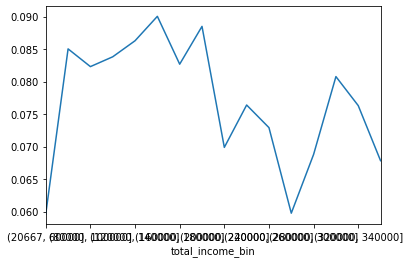

In [19]:
min_i = data_solvency['total_income'].min()
max_i = data_solvency['total_income'].max()
data_solvency['total_income_bin'] = pd.cut(data_solvency['total_income'], [min_i,60000, 80000, 100000,120000,140000,160000, 180000,200000,220000,240000,260000,280000,300000, 320000, 340000, max_i])
print(data_solvency.groupby('total_income_bin')['debt'].agg(['count', 'mean']))
data_solvency.groupby('total_income_bin')['debt'].mean().plot()


+ Проведена разбивка зарплаты на небольшие бины и построен график, отображающий зависимость доли просрочек от зарплаты.


+ Визуально можно выделить 3 интервала зарплат __(минимальная зарплата, 60000)__, __(60000, 200000)__ и __(200000, максимальная зарплата)__.

+ Проведена категоризация для двух столбцов разными способами. Цель этого действа - правильный анализ имеющейся информации и получение адекватных выводов.

### Шаг 3. Ответьте на вопросы

##### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [19]:
data_solvency.pivot_table(index='children_presence', values='debt').sort_values(by='debt', ascending=False)

,debt
children_presence,
1,0.092403
0,0.075419


Зависимость есть. Люди с детьми чаще допускают просрочки платежей.  По всей видимости связано это с тем, что дети являются дополнительной нагрузкой на семейный бюджет.

##### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [20]:
data_solvency.pivot_table(index='family_status', values='debt').sort_values(by='debt', ascending=False)

,debt
family_status,
Не женат / не замужем,0.097509
гражданский брак,0.093471
женат / замужем,0.075452
в разводе,0.071130
вдовец / вдова,0.065693


Зависимость наблюдается. Доля просрочек по платежам в группе лиц, не состоящих в браке, и лиц, состоящих в гражданском браке, выше, чем в других группах. Это может быть связано с тем, что среди лиц, не состоящих в браке или состоящих в гражданском браке, больше молодых людей по сравнению с лицами, состоящими в браке или потерявщими супруга/супругу. Люди более молодого возраста обладают меньшим жизненным опытом, хуже оценивают соотношение своих возможностей, потребностей и ресурсов. Кроме того, одинокие лица и лица, не состоящие в официальном браке, не обладают потенциальной финансовой поддержкой со стороны супруга, по сравнению с людьми, состоящими в официальном браке. Наименьшая доля просрочек по платежам наблюдается среди лиц, потерявших супруга/супругу. Можно предположить, что к данной группе относятся люди пожилого возраста. К этому возрасту, как правило, люди имеют больше накоплений, по сравнению с людьми более молодыми. Также можно предположить, что представители данной группы реже берут кредит, так как испытывают меньше потребностей по сравнению с молодыми людьми и молодыми семьями (нет потребности в отдельном жилье, в обеспечении детей, не трубеются деньги на свадьбу и т.д.). 

##### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

                   count      mean
total_income_bin                  
(20667, 60000]       805  0.059627
(60000, 200000]    15582  0.085612
(200000, 2265604]   5066  0.070667


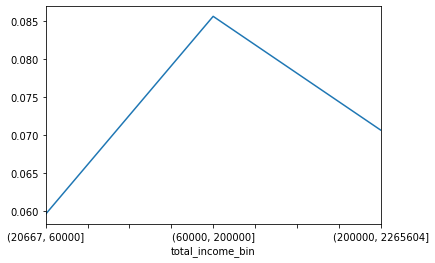

In [21]:
data_solvency['total_income_bin'] = pd.cut(data_solvency['total_income'], [min_i, 60000, 200000, max_i])
print(data_solvency.groupby('total_income_bin')['debt'].agg(['count', 'mean']))
data_solvency.groupby('total_income_bin')['debt'].mean().plot()

По соотношению зарплат и доле пропусков платежей можно выделить три характерные группы:
   1. Люди с "низким" доходом. Немногочисленная группа с наименьшим риском просрочки. Вероятно это обусловлено тем, что люди из этой группы редко берут кредиты, а если и берут, то на небольшие суммы, которые вполне могут себе позволить.
   1. Люди со "средним доходом". Самая многочисленная группа наиболее экономически активных людей. В том же время чаще других допускают просрочки. 
   1. Люди с "высоким" доходом. Доля просрочек в этой категории ниже, чем во второй. Вероятно потому что люди с большим достатком лучше планируют свой бюджет, ну и потому что у них есть деньги на оплату кредитов.

##### Как разные цели кредита влияют на его возврат в срок?

In [22]:
data_solvency.pivot_table(index='purpose_group', values='debt').sort_values(by='debt', ascending=False)

,debt
purpose_group,
автомобиль,0.093590
образование,0.092200
свадьба,0.080034
недвижимость,0.072334


Зависимость также прослеживается. Доля просрочек по кредитам взятых на покупку автомобиля и образования выше, чем на свадьбу или недвижимость. В некотором смысле, автомобиль и образование менее "надёжные" вложения: автомобиль несложно разбить, из университета лего быть отчисленным. В таких случаях у человека теряется мотивация к погашению кредита. К тому же автомобили могут покупать на эмоциях, понтов ради, не осознавая своего финансового положения в полной мере. Создание семьи и приобретение недвижимости вещи более серьёзные и к ним люди относятся ответственее. Потому по ним и просрочек меньше.

### Шаг 4. Общий вывод

+ В предоставленных данных были выявлены проблемы, такие как пропуски, повторы и значения не отражающие действительность. Об этом необходимо сообщить заказчику, для устранения этих проблем.



+ Был проведён анализ возврата кредита в срок по 4 параметрам, по каждому из них выявлены свои закономерности:  
    + __Наличие детей__ повышает долю просрочек.  
    + __Семейное положение__. Люди, не состоящие в официальном браке (не считая разведённых и вдовцов/вдов), наиболее проблемная группа.  
    + __Уровень доходов__ нелинейно влияет на риск просрочки. Так, благонадёжными заёмщиками являются люди с небольшим или же, наоборот, с очень большим достатком.  
    + __Цель кредита__ также влияет на его возврат в срок. Чаще всего просрочки по платежам совершают люди взявшие кредит на автомобиль или образование. 